In [1]:
import numpy as np
import pandas as pd
import os
import sys
import tqdm
sys.path.append('..')
from wombats.anomalies._base import deviation
from wombats.anomalies.increasing import *
from wombats.anomalies.invariant import *
from wombats.anomalies.decreasing import *
from wombats.datasets.data_utils import load_data_test
import matplotlib.pyplot as plt


## PREPARE DATASET

In [2]:
# Load data
data_type = 'ecg'

if data_type == 'ecg':
    channels = ['z']
    n = 256
    SNRdB = 40
elif data_type == 'bridge':
    channels = ['x']
    n = 100
    SNRdB = None
    
Xok_test = load_data_test(channels, n, data_type)[..., -1]

In [3]:
# The data is expected to split in n-dimensional windows, have unit power for each sample, and have 0 mean
Xok_test.shape, Xok_test.std(), Xok_test.mean()

((10000, 256), 0.9997302455751605, 0.005823361269882519)

## Generate Anomalies with a given deviation

In [4]:
delta = 0.8

In [5]:
anomalies_labels = [
    'GWN', 'Constant', 'Step', 'Impulse',
    'GNN',
    'TimeWarping', 'SpectralAlteration', 'PrincipalSubspaceAlteration',
    'MixingGWN', 'MixingConstant',
    'Clipping', 'Dead-Zone'
]

# create anomalies class instance
anomalies = [
    GWN(delta), Constant(delta), Step(delta), Impulse(delta),
    GNN(delta),
    TimeWarping(delta), SpectralAlteration(delta), PrincipalSubspaceAlteration(delta),
    MixingGWN(delta), MixingConstant(delta),
    Clipping(delta), DeadZone(delta)
]

anomalies_dict = dict(zip(anomalies_labels, anomalies))


In [6]:
# initialize the dataframe for anomalous data
Xko_df = pd.DataFrame(
    index=np.arange(Xok_test.shape[0]),
    columns=pd.MultiIndex.from_product([anomalies_labels, np.arange(Xok_test.shape[1])])
)

In [7]:
# generate anomalous data for each anomaly
for name, anomaly in tqdm.tqdm(anomalies_dict.items()):
    if name in ['SpectralAlteration']:
        anomaly.fit(Xok_test, SNRdB)
    else:
        anomaly.fit(Xok_test)
    # Xko_df.loc[0, name] = anomaly.distort(ECG_test.values[0])
    Xko_df[name] = anomaly.distort(Xok_test)

100%|██████████| 12/12 [02:12<00:00, 11.07s/it]


In [8]:
# check deviation levels through Monte Carlo
print('deviation for :\n')
for name in anomalies_dict.keys():
    print(f'{name}: {np.round(deviation(Xok_test, Xko_df[name].values), 3)}')

deviation for :

GWN: 0.8
Constant: 0.8
Step: 0.8
Impulse: 0.8
GNN: 0.803
TimeWarping: 0.8
SpectralAlteration: 0.8
PrincipalSubspaceAlteration: 0.8
MixingGWN: 0.8
MixingConstant: 0.801
Clipping: 0.798
Dead-Zone: 0.797


## Plot an example for each anomaly

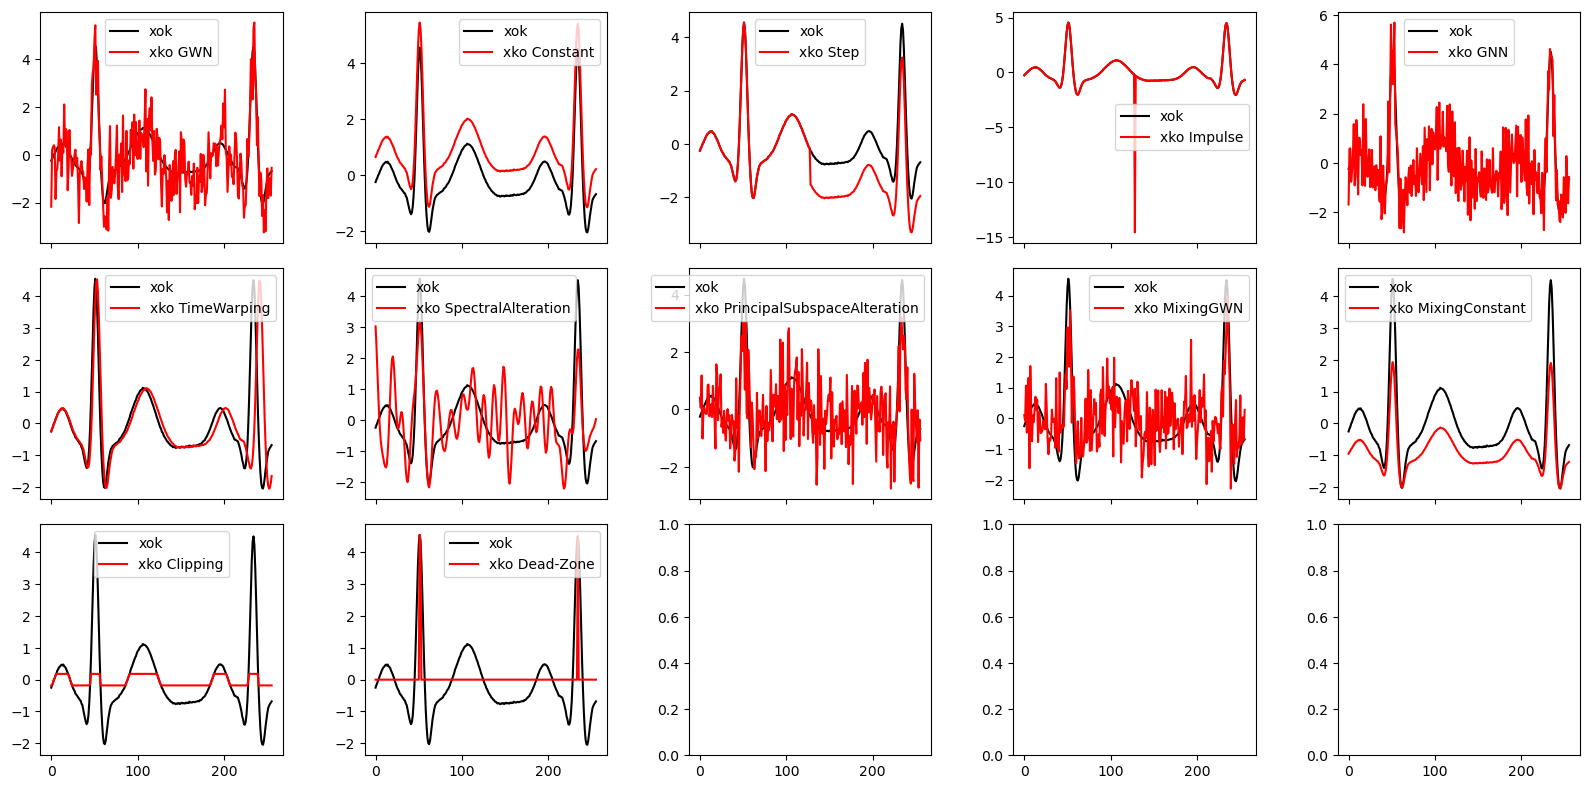

In [9]:
fig, ax = plt.subplots(3, 5, figsize=(16, 8), sharex=True, sharey=False)
ax = ax.flatten()
for name, ax_ in zip(anomalies_dict.keys(), ax):
    ax_.plot(Xok_test[100], label='xok', c='k')
    ax_.plot(Xko_df.loc[100, name], label=f'xko {name}', c='r')
    ax_.legend()
fig.tight_layout()